# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Helper Methods

## Show Image

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,])
    std = np.array([0.5,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Train helpers

In [ ]:
class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)

In [ ]:
class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')

In [ ]:
 def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):   

    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}


    for i_batch, (x, y) in enumerate(loader):
        x = x.float().to(device)
        y = y.long().to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
            
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
            
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics

In [ ]:
def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

# Database definition

In [ ]:
class FER2013Dataset(Dataset):
    """FER2013+ dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations_csv = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pixels = self.annotations_csv.iloc[idx]['pixels'].split()
        pixels = np.array(pixels, dtype=np.uint8)
        image = Image.fromarray(pixels.reshape(48,48), 'L')
        label = self.annotations_csv.iloc[idx]['class']

        if self.transform:
            image = self.transform(image)
        image= image.float()

        return image, label


Loading the data

1- Data transforms

In [ ]:
data_transforms = transforms.Compose([
        transforms.Grayscale(3),                              
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

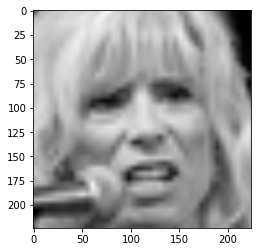

In [ ]:
df = pd.read_csv('test_b.csv')
pixels = df.iloc[4]['pixels'].split()
pixels = np.array(pixels, dtype=np.uint8)
image = Image.fromarray(pixels.reshape(48,48), 'L')
image = data_transforms(image)
imshow(image)

2- Loading and splitting the data

In [ ]:
batch_size = 32
# fer_train = FER2013Dataset(csv_file='train_b.csv', transform=data_transforms)
# fer_val = FER2013Dataset(csv_file='valid_b.csv', transform=data_transforms)
fer_test = FER2013Dataset(csv_file='test_b.csv', transform=data_transforms)

# dataset_sizes = {'train': len(fer_train), 'val': len(fer_val), 'test': len(fer_test) }

# train_loader = torch.utils.data.DataLoader(fer_train, batch_size=batch_size)
# val_loader = torch.utils.data.DataLoader(fer_val, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(fer_test, batch_size=batch_size)

print(len(test_loader))

class_names = {0: 'Active-Pleasant',
               1: 'Active-Unpleasant',
               2: 'Unactive-Unpleasant',
               3: 'Unactive-Pleasant'}

56


Show a batch of images

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(inputs)
print(labels)

imshow(out)

NameError: ignored

# The Model

## Model Definition

In [ ]:
class Resnet50_ferplus_dag(nn.Module):

    def __init__(self):
        super(Resnet50_ferplus_dag, self).__init__()
        self.meta = {'mean': [131.0912, 103.8827, 91.4953],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}

        from collections import OrderedDict
        self.debug_feats = OrderedDict() # only used for feature verification
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7_s2 = nn.ReLU()
        self.pool1_3x3_s2 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
        self.conv2_1_1x1_reduce = nn.Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_reduce_relu = nn.ReLU()
        self.conv2_1_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_1_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_3x3_relu = nn.ReLU()
        self.conv2_1_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_proj = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_proj_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_relu = nn.ReLU()
        self.conv2_2_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_1x1_reduce_relu = nn.ReLU()
        self.conv2_2_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_2_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_3x3_relu = nn.ReLU()
        self.conv2_2_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_relu = nn.ReLU()
        self.conv2_3_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_1x1_reduce_relu = nn.ReLU()
        self.conv2_3_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_3_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_3x3_relu = nn.ReLU()
        self.conv2_3_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_relu = nn.ReLU()
        self.conv3_1_1x1_reduce = nn.Conv2d(256, 128, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_reduce_relu = nn.ReLU()
        self.conv3_1_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_1_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_3x3_relu = nn.ReLU()
        self.conv3_1_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_1_1x1_proj = nn.Conv2d(256, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_proj_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_relu = nn.ReLU()
        self.conv3_2_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_1x1_reduce_relu = nn.ReLU()
        self.conv3_2_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_2_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_3x3_relu = nn.ReLU()
        self.conv3_2_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_relu = nn.ReLU()
        self.conv3_3_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_1x1_reduce_relu = nn.ReLU()
        self.conv3_3_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_3_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_3x3_relu = nn.ReLU()
        self.conv3_3_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_relu = nn.ReLU()
        self.conv3_4_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_1x1_reduce_relu = nn.ReLU()
        self.conv3_4_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_4_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_3x3_relu = nn.ReLU()
        self.conv3_4_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_relu = nn.ReLU()
        self.conv4_1_1x1_reduce = nn.Conv2d(512, 256, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_reduce_relu = nn.ReLU()
        self.conv4_1_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_1_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_3x3_relu = nn.ReLU()
        self.conv4_1_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_1_1x1_proj = nn.Conv2d(512, 1024, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_proj_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_relu = nn.ReLU()
        self.conv4_2_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_1x1_reduce_relu = nn.ReLU()
        self.conv4_2_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_2_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_3x3_relu = nn.ReLU()
        self.conv4_2_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_relu = nn.ReLU()
        self.conv4_3_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_1x1_reduce_relu = nn.ReLU()
        self.conv4_3_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_3_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_3x3_relu = nn.ReLU()
        self.conv4_3_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_relu = nn.ReLU()
        self.conv4_4_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_1x1_reduce_relu = nn.ReLU()
        self.conv4_4_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_4_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_3x3_relu = nn.ReLU()
        self.conv4_4_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_relu = nn.ReLU()
        self.conv4_5_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_1x1_reduce_relu = nn.ReLU()
        self.conv4_5_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_5_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_3x3_relu = nn.ReLU()
        self.conv4_5_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_relu = nn.ReLU()
        self.conv4_6_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_1x1_reduce_relu = nn.ReLU()
        self.conv4_6_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_6_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_3x3_relu = nn.ReLU()
        self.conv4_6_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_relu = nn.ReLU()
        self.conv5_1_1x1_reduce = nn.Conv2d(1024, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_reduce_relu = nn.ReLU()
        self.conv5_1_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_1_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_3x3_relu = nn.ReLU()
        self.conv5_1_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_1_1x1_proj = nn.Conv2d(1024, 2048, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_proj_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_relu = nn.ReLU()
        self.conv5_2_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_1x1_reduce_relu = nn.ReLU()
        self.conv5_2_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_2_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_3x3_relu = nn.ReLU()
        self.conv5_2_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_relu = nn.ReLU()
        self.conv5_3_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_1x1_reduce_relu = nn.ReLU()
        self.conv5_3_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_3_3x3_drop = nn.Dropout(p=0.5)
        self.conv5_3_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_3x3_relu = nn.ReLU()
        self.conv5_3_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_increase_drop = nn.Dropout(p=0.5)
        self.conv5_3_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_relu = nn.ReLU()
        self.pool5_7x7_s1 = nn.AvgPool2d(kernel_size=[7, 7], stride=[1, 1], padding=0)
        self.classifier = nn.Conv2d(2048, 8, kernel_size=[1, 1], stride=(1, 1))

    def forward(self, data):
        conv1_7x7_s2 = self.conv1_7x7_s2(data)
        conv1_7x7_s2_bn = self.conv1_7x7_s2_bn(conv1_7x7_s2)
        conv1_7x7_s2_bnxx = self.conv1_relu_7x7_s2(conv1_7x7_s2_bn)
        pool1_3x3_s2 = self.pool1_3x3_s2(conv1_7x7_s2_bnxx)
        conv2_1_1x1_reduce = self.conv2_1_1x1_reduce(pool1_3x3_s2)
        conv2_1_1x1_reduce_bn = self.conv2_1_1x1_reduce_bn(conv2_1_1x1_reduce)
        conv2_1_1x1_reduce_bnxx = self.conv2_1_1x1_reduce_relu(conv2_1_1x1_reduce_bn)
        conv2_1_3x3 = self.conv2_1_3x3(conv2_1_1x1_reduce_bnxx)
        conv2_1_3x3_bn = self.conv2_1_3x3_bn(conv2_1_3x3)
        conv2_1_3x3_bnxx = self.conv2_1_3x3_relu(conv2_1_3x3_bn)
        conv2_1_1x1_increase = self.conv2_1_1x1_increase(conv2_1_3x3_bnxx)
        conv2_1_1x1_proj = self.conv2_1_1x1_proj(pool1_3x3_s2)
        conv2_1_1x1_increase_bn = self.conv2_1_1x1_increase_bn(conv2_1_1x1_increase)
        conv2_1_1x1_proj_bn = self.conv2_1_1x1_proj_bn(conv2_1_1x1_proj)
        conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)
        conv2_1x = self.conv2_1_relu(conv2_1)
        conv2_2_1x1_reduce = self.conv2_2_1x1_reduce(conv2_1x)
        conv2_2_1x1_reduce_bn = self.conv2_2_1x1_reduce_bn(conv2_2_1x1_reduce)
        conv2_2_1x1_reduce_bnxx = self.conv2_2_1x1_reduce_relu(conv2_2_1x1_reduce_bn)
        conv2_2_3x3 = self.conv2_2_3x3(conv2_2_1x1_reduce_bnxx)
        conv2_2_3x3_bn = self.conv2_2_3x3_bn(conv2_2_3x3)
        conv2_2_3x3_bnxx = self.conv2_2_3x3_relu(conv2_2_3x3_bn)
        conv2_2_1x1_increase = self.conv2_2_1x1_increase(conv2_2_3x3_bnxx)
        conv2_2_1x1_increase_bn = self.conv2_2_1x1_increase_bn(conv2_2_1x1_increase)
        conv2_2 = torch.add(conv2_1x, 1, conv2_2_1x1_increase_bn)
        conv2_2x = self.conv2_2_relu(conv2_2)
        conv2_3_1x1_reduce = self.conv2_3_1x1_reduce(conv2_2x)
        conv2_3_1x1_reduce_bn = self.conv2_3_1x1_reduce_bn(conv2_3_1x1_reduce)
        conv2_3_1x1_reduce_bnxx = self.conv2_3_1x1_reduce_relu(conv2_3_1x1_reduce_bn)
        conv2_3_3x3 = self.conv2_3_3x3(conv2_3_1x1_reduce_bnxx)
        conv2_3_3x3_bn = self.conv2_3_3x3_bn(conv2_3_3x3)
        conv2_3_3x3_bnxx = self.conv2_3_3x3_relu(conv2_3_3x3_bn)
        conv2_3_1x1_increase = self.conv2_3_1x1_increase(conv2_3_3x3_bnxx)
        conv2_3_1x1_increase_bn = self.conv2_3_1x1_increase_bn(conv2_3_1x1_increase)
        conv2_3 = torch.add(conv2_2x, 1, conv2_3_1x1_increase_bn)
        conv2_3x = self.conv2_3_relu(conv2_3)
        conv3_1_1x1_reduce = self.conv3_1_1x1_reduce(conv2_3x)
        conv3_1_1x1_reduce_bn = self.conv3_1_1x1_reduce_bn(conv3_1_1x1_reduce)
        conv3_1_1x1_reduce_bnxx = self.conv3_1_1x1_reduce_relu(conv3_1_1x1_reduce_bn)
        conv3_1_3x3 = self.conv3_1_3x3(conv3_1_1x1_reduce_bnxx)
        conv3_1_3x3_bn = self.conv3_1_3x3_bn(conv3_1_3x3)
        conv3_1_3x3_bnxx = self.conv3_1_3x3_relu(conv3_1_3x3_bn)
        conv3_1_1x1_increase = self.conv3_1_1x1_increase(conv3_1_3x3_bnxx)
        conv3_1_1x1_proj = self.conv3_1_1x1_proj(conv2_3x)
        conv3_1_1x1_increase_bn = self.conv3_1_1x1_increase_bn(conv3_1_1x1_increase)
        conv3_1_1x1_proj_bn = self.conv3_1_1x1_proj_bn(conv3_1_1x1_proj)
        conv3_1 = torch.add(conv3_1_1x1_proj_bn, 1, conv3_1_1x1_increase_bn)
        conv3_1x = self.conv3_1_relu(conv3_1)
        conv3_2_1x1_reduce = self.conv3_2_1x1_reduce(conv3_1x)
        conv3_2_1x1_reduce_bn = self.conv3_2_1x1_reduce_bn(conv3_2_1x1_reduce)
        conv3_2_1x1_reduce_bnxx = self.conv3_2_1x1_reduce_relu(conv3_2_1x1_reduce_bn)
        conv3_2_3x3 = self.conv3_2_3x3(conv3_2_1x1_reduce_bnxx)
        conv3_2_3x3_bn = self.conv3_2_3x3_bn(conv3_2_3x3)
        conv3_2_3x3_bnxx = self.conv3_2_3x3_relu(conv3_2_3x3_bn)
        conv3_2_1x1_increase = self.conv3_2_1x1_increase(conv3_2_3x3_bnxx)
        conv3_2_1x1_increase_bn = self.conv3_2_1x1_increase_bn(conv3_2_1x1_increase)
        conv3_2 = torch.add(conv3_1x, 1, conv3_2_1x1_increase_bn)
        conv3_2x = self.conv3_2_relu(conv3_2)
        conv3_3_1x1_reduce = self.conv3_3_1x1_reduce(conv3_2x)
        conv3_3_1x1_reduce_bn = self.conv3_3_1x1_reduce_bn(conv3_3_1x1_reduce)
        conv3_3_1x1_reduce_bnxx = self.conv3_3_1x1_reduce_relu(conv3_3_1x1_reduce_bn)
        conv3_3_3x3 = self.conv3_3_3x3(conv3_3_1x1_reduce_bnxx)
        conv3_3_3x3_bn = self.conv3_3_3x3_bn(conv3_3_3x3)
        conv3_3_3x3_bnxx = self.conv3_3_3x3_relu(conv3_3_3x3_bn)
        conv3_3_1x1_increase = self.conv3_3_1x1_increase(conv3_3_3x3_bnxx)
        conv3_3_1x1_increase_bn = self.conv3_3_1x1_increase_bn(conv3_3_1x1_increase)
        conv3_3 = torch.add(conv3_2x, 1, conv3_3_1x1_increase_bn)
        conv3_3x = self.conv3_3_relu(conv3_3)
        conv3_4_1x1_reduce = self.conv3_4_1x1_reduce(conv3_3x)
        conv3_4_1x1_reduce_bn = self.conv3_4_1x1_reduce_bn(conv3_4_1x1_reduce)
        conv3_4_1x1_reduce_bnxx = self.conv3_4_1x1_reduce_relu(conv3_4_1x1_reduce_bn)
        conv3_4_3x3 = self.conv3_4_3x3(conv3_4_1x1_reduce_bnxx)
        conv3_4_3x3_bn = self.conv3_4_3x3_bn(conv3_4_3x3)
        conv3_4_3x3_bnxx = self.conv3_4_3x3_relu(conv3_4_3x3_bn)
        conv3_4_1x1_increase = self.conv3_4_1x1_increase(conv3_4_3x3_bnxx)
        conv3_4_1x1_increase_bn = self.conv3_4_1x1_increase_bn(conv3_4_1x1_increase)
        conv3_4 = torch.add(conv3_3x, 1, conv3_4_1x1_increase_bn)
        conv3_4x = self.conv3_4_relu(conv3_4)
        conv4_1_1x1_reduce = self.conv4_1_1x1_reduce(conv3_4x)
        conv4_1_1x1_reduce_bn = self.conv4_1_1x1_reduce_bn(conv4_1_1x1_reduce)
        conv4_1_1x1_reduce_bnxx = self.conv4_1_1x1_reduce_relu(conv4_1_1x1_reduce_bn)
        conv4_1_3x3 = self.conv4_1_3x3(conv4_1_1x1_reduce_bnxx)
        conv4_1_3x3_bn = self.conv4_1_3x3_bn(conv4_1_3x3)
        conv4_1_3x3_bnxx = self.conv4_1_3x3_relu(conv4_1_3x3_bn)
        conv4_1_1x1_increase = self.conv4_1_1x1_increase(conv4_1_3x3_bnxx)
        conv4_1_1x1_proj = self.conv4_1_1x1_proj(conv3_4x)
        conv4_1_1x1_increase_bn = self.conv4_1_1x1_increase_bn(conv4_1_1x1_increase)
        conv4_1_1x1_proj_bn = self.conv4_1_1x1_proj_bn(conv4_1_1x1_proj)
        conv4_1 = torch.add(conv4_1_1x1_proj_bn, 1, conv4_1_1x1_increase_bn)
        conv4_1x = self.conv4_1_relu(conv4_1)
        conv4_2_1x1_reduce = self.conv4_2_1x1_reduce(conv4_1x)
        conv4_2_1x1_reduce_bn = self.conv4_2_1x1_reduce_bn(conv4_2_1x1_reduce)
        conv4_2_1x1_reduce_bnxx = self.conv4_2_1x1_reduce_relu(conv4_2_1x1_reduce_bn)
        conv4_2_3x3 = self.conv4_2_3x3(conv4_2_1x1_reduce_bnxx)
        conv4_2_3x3_bn = self.conv4_2_3x3_bn(conv4_2_3x3)
        conv4_2_3x3_bnxx = self.conv4_2_3x3_relu(conv4_2_3x3_bn)
        conv4_2_1x1_increase = self.conv4_2_1x1_increase(conv4_2_3x3_bnxx)
        conv4_2_1x1_increase_bn = self.conv4_2_1x1_increase_bn(conv4_2_1x1_increase)
        conv4_2 = torch.add(conv4_1x, 1, conv4_2_1x1_increase_bn)
        conv4_2x = self.conv4_2_relu(conv4_2)
        conv4_3_1x1_reduce = self.conv4_3_1x1_reduce(conv4_2x)
        conv4_3_1x1_reduce_bn = self.conv4_3_1x1_reduce_bn(conv4_3_1x1_reduce)
        conv4_3_1x1_reduce_bnxx = self.conv4_3_1x1_reduce_relu(conv4_3_1x1_reduce_bn)
        conv4_3_3x3 = self.conv4_3_3x3(conv4_3_1x1_reduce_bnxx)
        conv4_3_3x3_bn = self.conv4_3_3x3_bn(conv4_3_3x3)
        conv4_3_3x3_bnxx = self.conv4_3_3x3_relu(conv4_3_3x3_bn)
        conv4_3_1x1_increase = self.conv4_3_1x1_increase(conv4_3_3x3_bnxx)
        conv4_3_1x1_increase_bn = self.conv4_3_1x1_increase_bn(conv4_3_1x1_increase)
        conv4_3 = torch.add(conv4_2x, 1, conv4_3_1x1_increase_bn)
        conv4_3x = self.conv4_3_relu(conv4_3)
        conv4_4_1x1_reduce = self.conv4_4_1x1_reduce(conv4_3x)
        conv4_4_1x1_reduce_bn = self.conv4_4_1x1_reduce_bn(conv4_4_1x1_reduce)
        conv4_4_1x1_reduce_bnxx = self.conv4_4_1x1_reduce_relu(conv4_4_1x1_reduce_bn)
        conv4_4_3x3 = self.conv4_4_3x3(conv4_4_1x1_reduce_bnxx)
        conv4_4_3x3_bn = self.conv4_4_3x3_bn(conv4_4_3x3)
        conv4_4_3x3_bnxx = self.conv4_4_3x3_relu(conv4_4_3x3_bn)
        conv4_4_1x1_increase = self.conv4_4_1x1_increase(conv4_4_3x3_bnxx)
        conv4_4_1x1_increase_bn = self.conv4_4_1x1_increase_bn(conv4_4_1x1_increase)
        conv4_4 = torch.add(conv4_3x, 1, conv4_4_1x1_increase_bn)
        conv4_4x = self.conv4_4_relu(conv4_4)
        conv4_5_1x1_reduce = self.conv4_5_1x1_reduce(conv4_4x)
        conv4_5_1x1_reduce_bn = self.conv4_5_1x1_reduce_bn(conv4_5_1x1_reduce)
        conv4_5_1x1_reduce_bnxx = self.conv4_5_1x1_reduce_relu(conv4_5_1x1_reduce_bn)
        conv4_5_3x3 = self.conv4_5_3x3(conv4_5_1x1_reduce_bnxx)
        conv4_5_3x3_bn = self.conv4_5_3x3_bn(conv4_5_3x3)
        conv4_5_3x3_bnxx = self.conv4_5_3x3_relu(conv4_5_3x3_bn)
        conv4_5_1x1_increase = self.conv4_5_1x1_increase(conv4_5_3x3_bnxx)
        conv4_5_1x1_increase_bn = self.conv4_5_1x1_increase_bn(conv4_5_1x1_increase)
        conv4_5 = torch.add(conv4_4x, 1, conv4_5_1x1_increase_bn)
        conv4_5x = self.conv4_5_relu(conv4_5)
        conv4_6_1x1_reduce = self.conv4_6_1x1_reduce(conv4_5x)
        conv4_6_1x1_reduce_bn = self.conv4_6_1x1_reduce_bn(conv4_6_1x1_reduce)
        conv4_6_1x1_reduce_bnxx = self.conv4_6_1x1_reduce_relu(conv4_6_1x1_reduce_bn)
        conv4_6_3x3 = self.conv4_6_3x3(conv4_6_1x1_reduce_bnxx)
        conv4_6_3x3_bn = self.conv4_6_3x3_bn(conv4_6_3x3)
        conv4_6_3x3_bnxx = self.conv4_6_3x3_relu(conv4_6_3x3_bn)
        conv4_6_1x1_increase = self.conv4_6_1x1_increase(conv4_6_3x3_bnxx)
        conv4_6_1x1_increase_bn = self.conv4_6_1x1_increase_bn(conv4_6_1x1_increase)
        conv4_6 = torch.add(conv4_5x, 1, conv4_6_1x1_increase_bn)
        conv4_6x = self.conv4_6_relu(conv4_6)
        conv5_1_1x1_reduce = self.conv5_1_1x1_reduce(conv4_6x)
        conv5_1_1x1_reduce_bn = self.conv5_1_1x1_reduce_bn(conv5_1_1x1_reduce)
        conv5_1_1x1_reduce_bnxx = self.conv5_1_1x1_reduce_relu(conv5_1_1x1_reduce_bn)
        conv5_1_3x3 = self.conv5_1_3x3(conv5_1_1x1_reduce_bnxx)
        conv5_1_3x3_bn = self.conv5_1_3x3_bn(conv5_1_3x3)
        conv5_1_3x3_bnxx = self.conv5_1_3x3_relu(conv5_1_3x3_bn)
        conv5_1_1x1_increase = self.conv5_1_1x1_increase(conv5_1_3x3_bnxx)
        conv5_1_1x1_proj = self.conv5_1_1x1_proj(conv4_6x)
        conv5_1_1x1_increase_bn = self.conv5_1_1x1_increase_bn(conv5_1_1x1_increase)
        conv5_1_1x1_proj_bn = self.conv5_1_1x1_proj_bn(conv5_1_1x1_proj)
        conv5_1 = torch.add(conv5_1_1x1_proj_bn, 1, conv5_1_1x1_increase_bn)
        conv5_1x = self.conv5_1_relu(conv5_1)
        conv5_2_1x1_reduce = self.conv5_2_1x1_reduce(conv5_1x)
        conv5_2_1x1_reduce_bn = self.conv5_2_1x1_reduce_bn(conv5_2_1x1_reduce)
        conv5_2_1x1_reduce_bnxx = self.conv5_2_1x1_reduce_relu(conv5_2_1x1_reduce_bn)
        conv5_2_3x3 = self.conv5_2_3x3(conv5_2_1x1_reduce_bnxx)
        conv5_2_3x3_bn = self.conv5_2_3x3_bn(conv5_2_3x3)
        conv5_2_3x3_bnxx = self.conv5_2_3x3_relu(conv5_2_3x3_bn)
        conv5_2_1x1_increase = self.conv5_2_1x1_increase(conv5_2_3x3_bnxx)
        conv5_2_1x1_increase_bn = self.conv5_2_1x1_increase_bn(conv5_2_1x1_increase)
        conv5_2 = torch.add(conv5_1x, 1, conv5_2_1x1_increase_bn)
        conv5_2x = self.conv5_2_relu(conv5_2)
        conv5_3_1x1_reduce = self.conv5_3_1x1_reduce(conv5_2x)
        conv5_3_1x1_reduce_bn = self.conv5_3_1x1_reduce_bn(conv5_3_1x1_reduce)
        conv5_3_1x1_reduce_bnxx = self.conv5_3_1x1_reduce_relu(conv5_3_1x1_reduce_bn)
        conv5_3_3x3 = self.conv5_3_3x3(conv5_3_1x1_reduce_bnxx)
        conv5_3_3x3_drop = self.conv5_3_3x3_drop(conv5_3_3x3)
        conv5_3_3x3_bn = self.conv5_3_3x3_bn(conv5_3_3x3_drop)
        conv5_3_3x3_bnxx = self.conv5_3_3x3_relu(conv5_3_3x3_bn)
        conv5_3_1x1_increase = self.conv5_3_1x1_increase(conv5_3_3x3_bnxx)
        conv5_3_1x1_increase_drop = self.conv5_3_1x1_increase_drop(conv5_3_1x1_increase)
        conv5_3_1x1_increase_bn = self.conv5_3_1x1_increase_bn(conv5_3_1x1_increase_drop)
        conv5_3 = torch.add(conv5_2x, 1, conv5_3_1x1_increase_bn)
        conv5_3x = self.conv5_3_relu(conv5_3)
        pool5_7x7_s1 = self.pool5_7x7_s1(conv5_3x)
        prediction = self.classifier(pool5_7x7_s1)
        return prediction

    def forward_debug(self, data):
        """ This purpose of this function is to provide an easy debugging
        utility for the converted network.  Cloning is used to prevent in-place
        operations from modifying feature artefacts. You can prevent the
        generation of this function by setting `debug_mode = False` in the
        importer tool.
        """
        conv1_7x7_s2 = self.conv1_7x7_s2(data)
        self.debug_feats['conv1_7x7_s2'] = conv1_7x7_s2.clone()
        conv1_7x7_s2_bn = self.conv1_7x7_s2_bn(conv1_7x7_s2)
        self.debug_feats['conv1_7x7_s2_bn'] = conv1_7x7_s2_bn.clone()
        conv1_7x7_s2_bnxx = self.conv1_relu_7x7_s2(conv1_7x7_s2_bn)
        self.debug_feats['conv1_7x7_s2_bnxx'] = conv1_7x7_s2_bnxx.clone()
        pool1_3x3_s2 = self.pool1_3x3_s2(conv1_7x7_s2_bnxx)
        self.debug_feats['pool1_3x3_s2'] = pool1_3x3_s2.clone()
        conv2_1_1x1_reduce = self.conv2_1_1x1_reduce(pool1_3x3_s2)
        self.debug_feats['conv2_1_1x1_reduce'] = conv2_1_1x1_reduce.clone()
        conv2_1_1x1_reduce_bn = self.conv2_1_1x1_reduce_bn(conv2_1_1x1_reduce)
        self.debug_feats['conv2_1_1x1_reduce_bn'] = conv2_1_1x1_reduce_bn.clone()
        conv2_1_1x1_reduce_bnxx = self.conv2_1_1x1_reduce_relu(conv2_1_1x1_reduce_bn)
        self.debug_feats['conv2_1_1x1_reduce_bnxx'] = conv2_1_1x1_reduce_bnxx.clone()
        conv2_1_3x3 = self.conv2_1_3x3(conv2_1_1x1_reduce_bnxx)
        self.debug_feats['conv2_1_3x3'] = conv2_1_3x3.clone()
        conv2_1_3x3_bn = self.conv2_1_3x3_bn(conv2_1_3x3)
        self.debug_feats['conv2_1_3x3_bn'] = conv2_1_3x3_bn.clone()
        conv2_1_3x3_bnxx = self.conv2_1_3x3_relu(conv2_1_3x3_bn)
        self.debug_feats['conv2_1_3x3_bnxx'] = conv2_1_3x3_bnxx.clone()
        conv2_1_1x1_increase = self.conv2_1_1x1_increase(conv2_1_3x3_bnxx)
        self.debug_feats['conv2_1_1x1_increase'] = conv2_1_1x1_increase.clone()
        conv2_1_1x1_proj = self.conv2_1_1x1_proj(pool1_3x3_s2)
        self.debug_feats['conv2_1_1x1_proj'] = conv2_1_1x1_proj.clone()
        conv2_1_1x1_increase_bn = self.conv2_1_1x1_increase_bn(conv2_1_1x1_increase)
        self.debug_feats['conv2_1_1x1_increase_bn'] = conv2_1_1x1_increase_bn.clone()
        conv2_1_1x1_proj_bn = self.conv2_1_1x1_proj_bn(conv2_1_1x1_proj)
        self.debug_feats['conv2_1_1x1_proj_bn'] = conv2_1_1x1_proj_bn.clone()
        conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)
        self.debug_feats['conv2_1'] = conv2_1.clone()
        conv2_1x = self.conv2_1_relu(conv2_1)
        self.debug_feats['conv2_1x'] = conv2_1x.clone()
        conv2_2_1x1_reduce = self.conv2_2_1x1_reduce(conv2_1x)
        self.debug_feats['conv2_2_1x1_reduce'] = conv2_2_1x1_reduce.clone()
        conv2_2_1x1_reduce_bn = self.conv2_2_1x1_reduce_bn(conv2_2_1x1_reduce)
        self.debug_feats['conv2_2_1x1_reduce_bn'] = conv2_2_1x1_reduce_bn.clone()
        conv2_2_1x1_reduce_bnxx = self.conv2_2_1x1_reduce_relu(conv2_2_1x1_reduce_bn)
        self.debug_feats['conv2_2_1x1_reduce_bnxx'] = conv2_2_1x1_reduce_bnxx.clone()
        conv2_2_3x3 = self.conv2_2_3x3(conv2_2_1x1_reduce_bnxx)
        self.debug_feats['conv2_2_3x3'] = conv2_2_3x3.clone()
        conv2_2_3x3_bn = self.conv2_2_3x3_bn(conv2_2_3x3)
        self.debug_feats['conv2_2_3x3_bn'] = conv2_2_3x3_bn.clone()
        conv2_2_3x3_bnxx = self.conv2_2_3x3_relu(conv2_2_3x3_bn)
        self.debug_feats['conv2_2_3x3_bnxx'] = conv2_2_3x3_bnxx.clone()
        conv2_2_1x1_increase = self.conv2_2_1x1_increase(conv2_2_3x3_bnxx)
        self.debug_feats['conv2_2_1x1_increase'] = conv2_2_1x1_increase.clone()
        conv2_2_1x1_increase_bn = self.conv2_2_1x1_increase_bn(conv2_2_1x1_increase)
        self.debug_feats['conv2_2_1x1_increase_bn'] = conv2_2_1x1_increase_bn.clone()
        conv2_2 = torch.add(conv2_1x, 1, conv2_2_1x1_increase_bn)
        self.debug_feats['conv2_2'] = conv2_2.clone()
        conv2_2x = self.conv2_2_relu(conv2_2)
        self.debug_feats['conv2_2x'] = conv2_2x.clone()
        conv2_3_1x1_reduce = self.conv2_3_1x1_reduce(conv2_2x)
        self.debug_feats['conv2_3_1x1_reduce'] = conv2_3_1x1_reduce.clone()
        conv2_3_1x1_reduce_bn = self.conv2_3_1x1_reduce_bn(conv2_3_1x1_reduce)
        self.debug_feats['conv2_3_1x1_reduce_bn'] = conv2_3_1x1_reduce_bn.clone()
        conv2_3_1x1_reduce_bnxx = self.conv2_3_1x1_reduce_relu(conv2_3_1x1_reduce_bn)
        self.debug_feats['conv2_3_1x1_reduce_bnxx'] = conv2_3_1x1_reduce_bnxx.clone()
        conv2_3_3x3 = self.conv2_3_3x3(conv2_3_1x1_reduce_bnxx)
        self.debug_feats['conv2_3_3x3'] = conv2_3_3x3.clone()
        conv2_3_3x3_bn = self.conv2_3_3x3_bn(conv2_3_3x3)
        self.debug_feats['conv2_3_3x3_bn'] = conv2_3_3x3_bn.clone()
        conv2_3_3x3_bnxx = self.conv2_3_3x3_relu(conv2_3_3x3_bn)
        self.debug_feats['conv2_3_3x3_bnxx'] = conv2_3_3x3_bnxx.clone()
        conv2_3_1x1_increase = self.conv2_3_1x1_increase(conv2_3_3x3_bnxx)
        self.debug_feats['conv2_3_1x1_increase'] = conv2_3_1x1_increase.clone()
        conv2_3_1x1_increase_bn = self.conv2_3_1x1_increase_bn(conv2_3_1x1_increase)
        self.debug_feats['conv2_3_1x1_increase_bn'] = conv2_3_1x1_increase_bn.clone()
        conv2_3 = torch.add(conv2_2x, 1, conv2_3_1x1_increase_bn)
        self.debug_feats['conv2_3'] = conv2_3.clone()
        conv2_3x = self.conv2_3_relu(conv2_3)
        self.debug_feats['conv2_3x'] = conv2_3x.clone()
        conv3_1_1x1_reduce = self.conv3_1_1x1_reduce(conv2_3x)
        self.debug_feats['conv3_1_1x1_reduce'] = conv3_1_1x1_reduce.clone()
        conv3_1_1x1_reduce_bn = self.conv3_1_1x1_reduce_bn(conv3_1_1x1_reduce)
        self.debug_feats['conv3_1_1x1_reduce_bn'] = conv3_1_1x1_reduce_bn.clone()
        conv3_1_1x1_reduce_bnxx = self.conv3_1_1x1_reduce_relu(conv3_1_1x1_reduce_bn)
        self.debug_feats['conv3_1_1x1_reduce_bnxx'] = conv3_1_1x1_reduce_bnxx.clone()
        conv3_1_3x3 = self.conv3_1_3x3(conv3_1_1x1_reduce_bnxx)
        self.debug_feats['conv3_1_3x3'] = conv3_1_3x3.clone()
        conv3_1_3x3_bn = self.conv3_1_3x3_bn(conv3_1_3x3)
        self.debug_feats['conv3_1_3x3_bn'] = conv3_1_3x3_bn.clone()
        conv3_1_3x3_bnxx = self.conv3_1_3x3_relu(conv3_1_3x3_bn)
        self.debug_feats['conv3_1_3x3_bnxx'] = conv3_1_3x3_bnxx.clone()
        conv3_1_1x1_increase = self.conv3_1_1x1_increase(conv3_1_3x3_bnxx)
        self.debug_feats['conv3_1_1x1_increase'] = conv3_1_1x1_increase.clone()
        conv3_1_1x1_proj = self.conv3_1_1x1_proj(conv2_3x)
        self.debug_feats['conv3_1_1x1_proj'] = conv3_1_1x1_proj.clone()
        conv3_1_1x1_increase_bn = self.conv3_1_1x1_increase_bn(conv3_1_1x1_increase)
        self.debug_feats['conv3_1_1x1_increase_bn'] = conv3_1_1x1_increase_bn.clone()
        conv3_1_1x1_proj_bn = self.conv3_1_1x1_proj_bn(conv3_1_1x1_proj)
        self.debug_feats['conv3_1_1x1_proj_bn'] = conv3_1_1x1_proj_bn.clone()
        conv3_1 = torch.add(conv3_1_1x1_proj_bn, 1, conv3_1_1x1_increase_bn)
        self.debug_feats['conv3_1'] = conv3_1.clone()
        conv3_1x = self.conv3_1_relu(conv3_1)
        self.debug_feats['conv3_1x'] = conv3_1x.clone()
        conv3_2_1x1_reduce = self.conv3_2_1x1_reduce(conv3_1x)
        self.debug_feats['conv3_2_1x1_reduce'] = conv3_2_1x1_reduce.clone()
        conv3_2_1x1_reduce_bn = self.conv3_2_1x1_reduce_bn(conv3_2_1x1_reduce)
        self.debug_feats['conv3_2_1x1_reduce_bn'] = conv3_2_1x1_reduce_bn.clone()
        conv3_2_1x1_reduce_bnxx = self.conv3_2_1x1_reduce_relu(conv3_2_1x1_reduce_bn)
        self.debug_feats['conv3_2_1x1_reduce_bnxx'] = conv3_2_1x1_reduce_bnxx.clone()
        conv3_2_3x3 = self.conv3_2_3x3(conv3_2_1x1_reduce_bnxx)
        self.debug_feats['conv3_2_3x3'] = conv3_2_3x3.clone()
        conv3_2_3x3_bn = self.conv3_2_3x3_bn(conv3_2_3x3)
        self.debug_feats['conv3_2_3x3_bn'] = conv3_2_3x3_bn.clone()
        conv3_2_3x3_bnxx = self.conv3_2_3x3_relu(conv3_2_3x3_bn)
        self.debug_feats['conv3_2_3x3_bnxx'] = conv3_2_3x3_bnxx.clone()
        conv3_2_1x1_increase = self.conv3_2_1x1_increase(conv3_2_3x3_bnxx)
        self.debug_feats['conv3_2_1x1_increase'] = conv3_2_1x1_increase.clone()
        conv3_2_1x1_increase_bn = self.conv3_2_1x1_increase_bn(conv3_2_1x1_increase)
        self.debug_feats['conv3_2_1x1_increase_bn'] = conv3_2_1x1_increase_bn.clone()
        conv3_2 = torch.add(conv3_1x, 1, conv3_2_1x1_increase_bn)
        self.debug_feats['conv3_2'] = conv3_2.clone()
        conv3_2x = self.conv3_2_relu(conv3_2)
        self.debug_feats['conv3_2x'] = conv3_2x.clone()
        conv3_3_1x1_reduce = self.conv3_3_1x1_reduce(conv3_2x)
        self.debug_feats['conv3_3_1x1_reduce'] = conv3_3_1x1_reduce.clone()
        conv3_3_1x1_reduce_bn = self.conv3_3_1x1_reduce_bn(conv3_3_1x1_reduce)
        self.debug_feats['conv3_3_1x1_reduce_bn'] = conv3_3_1x1_reduce_bn.clone()
        conv3_3_1x1_reduce_bnxx = self.conv3_3_1x1_reduce_relu(conv3_3_1x1_reduce_bn)
        self.debug_feats['conv3_3_1x1_reduce_bnxx'] = conv3_3_1x1_reduce_bnxx.clone()
        conv3_3_3x3 = self.conv3_3_3x3(conv3_3_1x1_reduce_bnxx)
        self.debug_feats['conv3_3_3x3'] = conv3_3_3x3.clone()
        conv3_3_3x3_bn = self.conv3_3_3x3_bn(conv3_3_3x3)
        self.debug_feats['conv3_3_3x3_bn'] = conv3_3_3x3_bn.clone()
        conv3_3_3x3_bnxx = self.conv3_3_3x3_relu(conv3_3_3x3_bn)
        self.debug_feats['conv3_3_3x3_bnxx'] = conv3_3_3x3_bnxx.clone()
        conv3_3_1x1_increase = self.conv3_3_1x1_increase(conv3_3_3x3_bnxx)
        self.debug_feats['conv3_3_1x1_increase'] = conv3_3_1x1_increase.clone()
        conv3_3_1x1_increase_bn = self.conv3_3_1x1_increase_bn(conv3_3_1x1_increase)
        self.debug_feats['conv3_3_1x1_increase_bn'] = conv3_3_1x1_increase_bn.clone()
        conv3_3 = torch.add(conv3_2x, 1, conv3_3_1x1_increase_bn)
        self.debug_feats['conv3_3'] = conv3_3.clone()
        conv3_3x = self.conv3_3_relu(conv3_3)
        self.debug_feats['conv3_3x'] = conv3_3x.clone()
        conv3_4_1x1_reduce = self.conv3_4_1x1_reduce(conv3_3x)
        self.debug_feats['conv3_4_1x1_reduce'] = conv3_4_1x1_reduce.clone()
        conv3_4_1x1_reduce_bn = self.conv3_4_1x1_reduce_bn(conv3_4_1x1_reduce)
        self.debug_feats['conv3_4_1x1_reduce_bn'] = conv3_4_1x1_reduce_bn.clone()
        conv3_4_1x1_reduce_bnxx = self.conv3_4_1x1_reduce_relu(conv3_4_1x1_reduce_bn)
        self.debug_feats['conv3_4_1x1_reduce_bnxx'] = conv3_4_1x1_reduce_bnxx.clone()
        conv3_4_3x3 = self.conv3_4_3x3(conv3_4_1x1_reduce_bnxx)
        self.debug_feats['conv3_4_3x3'] = conv3_4_3x3.clone()
        conv3_4_3x3_bn = self.conv3_4_3x3_bn(conv3_4_3x3)
        self.debug_feats['conv3_4_3x3_bn'] = conv3_4_3x3_bn.clone()
        conv3_4_3x3_bnxx = self.conv3_4_3x3_relu(conv3_4_3x3_bn)
        self.debug_feats['conv3_4_3x3_bnxx'] = conv3_4_3x3_bnxx.clone()
        conv3_4_1x1_increase = self.conv3_4_1x1_increase(conv3_4_3x3_bnxx)
        self.debug_feats['conv3_4_1x1_increase'] = conv3_4_1x1_increase.clone()
        conv3_4_1x1_increase_bn = self.conv3_4_1x1_increase_bn(conv3_4_1x1_increase)
        self.debug_feats['conv3_4_1x1_increase_bn'] = conv3_4_1x1_increase_bn.clone()
        conv3_4 = torch.add(conv3_3x, 1, conv3_4_1x1_increase_bn)
        self.debug_feats['conv3_4'] = conv3_4.clone()
        conv3_4x = self.conv3_4_relu(conv3_4)
        self.debug_feats['conv3_4x'] = conv3_4x.clone()
        conv4_1_1x1_reduce = self.conv4_1_1x1_reduce(conv3_4x)
        self.debug_feats['conv4_1_1x1_reduce'] = conv4_1_1x1_reduce.clone()
        conv4_1_1x1_reduce_bn = self.conv4_1_1x1_reduce_bn(conv4_1_1x1_reduce)
        self.debug_feats['conv4_1_1x1_reduce_bn'] = conv4_1_1x1_reduce_bn.clone()
        conv4_1_1x1_reduce_bnxx = self.conv4_1_1x1_reduce_relu(conv4_1_1x1_reduce_bn)
        self.debug_feats['conv4_1_1x1_reduce_bnxx'] = conv4_1_1x1_reduce_bnxx.clone()
        conv4_1_3x3 = self.conv4_1_3x3(conv4_1_1x1_reduce_bnxx)
        self.debug_feats['conv4_1_3x3'] = conv4_1_3x3.clone()
        conv4_1_3x3_bn = self.conv4_1_3x3_bn(conv4_1_3x3)
        self.debug_feats['conv4_1_3x3_bn'] = conv4_1_3x3_bn.clone()
        conv4_1_3x3_bnxx = self.conv4_1_3x3_relu(conv4_1_3x3_bn)
        self.debug_feats['conv4_1_3x3_bnxx'] = conv4_1_3x3_bnxx.clone()
        conv4_1_1x1_increase = self.conv4_1_1x1_increase(conv4_1_3x3_bnxx)
        self.debug_feats['conv4_1_1x1_increase'] = conv4_1_1x1_increase.clone()
        conv4_1_1x1_proj = self.conv4_1_1x1_proj(conv3_4x)
        self.debug_feats['conv4_1_1x1_proj'] = conv4_1_1x1_proj.clone()
        conv4_1_1x1_increase_bn = self.conv4_1_1x1_increase_bn(conv4_1_1x1_increase)
        self.debug_feats['conv4_1_1x1_increase_bn'] = conv4_1_1x1_increase_bn.clone()
        conv4_1_1x1_proj_bn = self.conv4_1_1x1_proj_bn(conv4_1_1x1_proj)
        self.debug_feats['conv4_1_1x1_proj_bn'] = conv4_1_1x1_proj_bn.clone()
        conv4_1 = torch.add(conv4_1_1x1_proj_bn, 1, conv4_1_1x1_increase_bn)
        self.debug_feats['conv4_1'] = conv4_1.clone()
        conv4_1x = self.conv4_1_relu(conv4_1)
        self.debug_feats['conv4_1x'] = conv4_1x.clone()
        conv4_2_1x1_reduce = self.conv4_2_1x1_reduce(conv4_1x)
        self.debug_feats['conv4_2_1x1_reduce'] = conv4_2_1x1_reduce.clone()
        conv4_2_1x1_reduce_bn = self.conv4_2_1x1_reduce_bn(conv4_2_1x1_reduce)
        self.debug_feats['conv4_2_1x1_reduce_bn'] = conv4_2_1x1_reduce_bn.clone()
        conv4_2_1x1_reduce_bnxx = self.conv4_2_1x1_reduce_relu(conv4_2_1x1_reduce_bn)
        self.debug_feats['conv4_2_1x1_reduce_bnxx'] = conv4_2_1x1_reduce_bnxx.clone()
        conv4_2_3x3 = self.conv4_2_3x3(conv4_2_1x1_reduce_bnxx)
        self.debug_feats['conv4_2_3x3'] = conv4_2_3x3.clone()
        conv4_2_3x3_bn = self.conv4_2_3x3_bn(conv4_2_3x3)
        self.debug_feats['conv4_2_3x3_bn'] = conv4_2_3x3_bn.clone()
        conv4_2_3x3_bnxx = self.conv4_2_3x3_relu(conv4_2_3x3_bn)
        self.debug_feats['conv4_2_3x3_bnxx'] = conv4_2_3x3_bnxx.clone()
        conv4_2_1x1_increase = self.conv4_2_1x1_increase(conv4_2_3x3_bnxx)
        self.debug_feats['conv4_2_1x1_increase'] = conv4_2_1x1_increase.clone()
        conv4_2_1x1_increase_bn = self.conv4_2_1x1_increase_bn(conv4_2_1x1_increase)
        self.debug_feats['conv4_2_1x1_increase_bn'] = conv4_2_1x1_increase_bn.clone()
        conv4_2 = torch.add(conv4_1x, 1, conv4_2_1x1_increase_bn)
        self.debug_feats['conv4_2'] = conv4_2.clone()
        conv4_2x = self.conv4_2_relu(conv4_2)
        self.debug_feats['conv4_2x'] = conv4_2x.clone()
        conv4_3_1x1_reduce = self.conv4_3_1x1_reduce(conv4_2x)
        self.debug_feats['conv4_3_1x1_reduce'] = conv4_3_1x1_reduce.clone()
        conv4_3_1x1_reduce_bn = self.conv4_3_1x1_reduce_bn(conv4_3_1x1_reduce)
        self.debug_feats['conv4_3_1x1_reduce_bn'] = conv4_3_1x1_reduce_bn.clone()
        conv4_3_1x1_reduce_bnxx = self.conv4_3_1x1_reduce_relu(conv4_3_1x1_reduce_bn)
        self.debug_feats['conv4_3_1x1_reduce_bnxx'] = conv4_3_1x1_reduce_bnxx.clone()
        conv4_3_3x3 = self.conv4_3_3x3(conv4_3_1x1_reduce_bnxx)
        self.debug_feats['conv4_3_3x3'] = conv4_3_3x3.clone()
        conv4_3_3x3_bn = self.conv4_3_3x3_bn(conv4_3_3x3)
        self.debug_feats['conv4_3_3x3_bn'] = conv4_3_3x3_bn.clone()
        conv4_3_3x3_bnxx = self.conv4_3_3x3_relu(conv4_3_3x3_bn)
        self.debug_feats['conv4_3_3x3_bnxx'] = conv4_3_3x3_bnxx.clone()
        conv4_3_1x1_increase = self.conv4_3_1x1_increase(conv4_3_3x3_bnxx)
        self.debug_feats['conv4_3_1x1_increase'] = conv4_3_1x1_increase.clone()
        conv4_3_1x1_increase_bn = self.conv4_3_1x1_increase_bn(conv4_3_1x1_increase)
        self.debug_feats['conv4_3_1x1_increase_bn'] = conv4_3_1x1_increase_bn.clone()
        conv4_3 = torch.add(conv4_2x, 1, conv4_3_1x1_increase_bn)
        self.debug_feats['conv4_3'] = conv4_3.clone()
        conv4_3x = self.conv4_3_relu(conv4_3)
        self.debug_feats['conv4_3x'] = conv4_3x.clone()
        conv4_4_1x1_reduce = self.conv4_4_1x1_reduce(conv4_3x)
        self.debug_feats['conv4_4_1x1_reduce'] = conv4_4_1x1_reduce.clone()
        conv4_4_1x1_reduce_bn = self.conv4_4_1x1_reduce_bn(conv4_4_1x1_reduce)
        self.debug_feats['conv4_4_1x1_reduce_bn'] = conv4_4_1x1_reduce_bn.clone()
        conv4_4_1x1_reduce_bnxx = self.conv4_4_1x1_reduce_relu(conv4_4_1x1_reduce_bn)
        self.debug_feats['conv4_4_1x1_reduce_bnxx'] = conv4_4_1x1_reduce_bnxx.clone()
        conv4_4_3x3 = self.conv4_4_3x3(conv4_4_1x1_reduce_bnxx)
        self.debug_feats['conv4_4_3x3'] = conv4_4_3x3.clone()
        conv4_4_3x3_bn = self.conv4_4_3x3_bn(conv4_4_3x3)
        self.debug_feats['conv4_4_3x3_bn'] = conv4_4_3x3_bn.clone()
        conv4_4_3x3_bnxx = self.conv4_4_3x3_relu(conv4_4_3x3_bn)
        self.debug_feats['conv4_4_3x3_bnxx'] = conv4_4_3x3_bnxx.clone()
        conv4_4_1x1_increase = self.conv4_4_1x1_increase(conv4_4_3x3_bnxx)
        self.debug_feats['conv4_4_1x1_increase'] = conv4_4_1x1_increase.clone()
        conv4_4_1x1_increase_bn = self.conv4_4_1x1_increase_bn(conv4_4_1x1_increase)
        self.debug_feats['conv4_4_1x1_increase_bn'] = conv4_4_1x1_increase_bn.clone()
        conv4_4 = torch.add(conv4_3x, 1, conv4_4_1x1_increase_bn)
        self.debug_feats['conv4_4'] = conv4_4.clone()
        conv4_4x = self.conv4_4_relu(conv4_4)
        self.debug_feats['conv4_4x'] = conv4_4x.clone()
        conv4_5_1x1_reduce = self.conv4_5_1x1_reduce(conv4_4x)
        self.debug_feats['conv4_5_1x1_reduce'] = conv4_5_1x1_reduce.clone()
        conv4_5_1x1_reduce_bn = self.conv4_5_1x1_reduce_bn(conv4_5_1x1_reduce)
        self.debug_feats['conv4_5_1x1_reduce_bn'] = conv4_5_1x1_reduce_bn.clone()
        conv4_5_1x1_reduce_bnxx = self.conv4_5_1x1_reduce_relu(conv4_5_1x1_reduce_bn)
        self.debug_feats['conv4_5_1x1_reduce_bnxx'] = conv4_5_1x1_reduce_bnxx.clone()
        conv4_5_3x3 = self.conv4_5_3x3(conv4_5_1x1_reduce_bnxx)
        self.debug_feats['conv4_5_3x3'] = conv4_5_3x3.clone()
        conv4_5_3x3_bn = self.conv4_5_3x3_bn(conv4_5_3x3)
        self.debug_feats['conv4_5_3x3_bn'] = conv4_5_3x3_bn.clone()
        conv4_5_3x3_bnxx = self.conv4_5_3x3_relu(conv4_5_3x3_bn)
        self.debug_feats['conv4_5_3x3_bnxx'] = conv4_5_3x3_bnxx.clone()
        conv4_5_1x1_increase = self.conv4_5_1x1_increase(conv4_5_3x3_bnxx)
        self.debug_feats['conv4_5_1x1_increase'] = conv4_5_1x1_increase.clone()
        conv4_5_1x1_increase_bn = self.conv4_5_1x1_increase_bn(conv4_5_1x1_increase)
        self.debug_feats['conv4_5_1x1_increase_bn'] = conv4_5_1x1_increase_bn.clone()
        conv4_5 = torch.add(conv4_4x, 1, conv4_5_1x1_increase_bn)
        self.debug_feats['conv4_5'] = conv4_5.clone()
        conv4_5x = self.conv4_5_relu(conv4_5)
        self.debug_feats['conv4_5x'] = conv4_5x.clone()
        conv4_6_1x1_reduce = self.conv4_6_1x1_reduce(conv4_5x)
        self.debug_feats['conv4_6_1x1_reduce'] = conv4_6_1x1_reduce.clone()
        conv4_6_1x1_reduce_bn = self.conv4_6_1x1_reduce_bn(conv4_6_1x1_reduce)
        self.debug_feats['conv4_6_1x1_reduce_bn'] = conv4_6_1x1_reduce_bn.clone()
        conv4_6_1x1_reduce_bnxx = self.conv4_6_1x1_reduce_relu(conv4_6_1x1_reduce_bn)
        self.debug_feats['conv4_6_1x1_reduce_bnxx'] = conv4_6_1x1_reduce_bnxx.clone()
        conv4_6_3x3 = self.conv4_6_3x3(conv4_6_1x1_reduce_bnxx)
        self.debug_feats['conv4_6_3x3'] = conv4_6_3x3.clone()
        conv4_6_3x3_bn = self.conv4_6_3x3_bn(conv4_6_3x3)
        self.debug_feats['conv4_6_3x3_bn'] = conv4_6_3x3_bn.clone()
        conv4_6_3x3_bnxx = self.conv4_6_3x3_relu(conv4_6_3x3_bn)
        self.debug_feats['conv4_6_3x3_bnxx'] = conv4_6_3x3_bnxx.clone()
        conv4_6_1x1_increase = self.conv4_6_1x1_increase(conv4_6_3x3_bnxx)
        self.debug_feats['conv4_6_1x1_increase'] = conv4_6_1x1_increase.clone()
        conv4_6_1x1_increase_bn = self.conv4_6_1x1_increase_bn(conv4_6_1x1_increase)
        self.debug_feats['conv4_6_1x1_increase_bn'] = conv4_6_1x1_increase_bn.clone()
        conv4_6 = torch.add(conv4_5x, 1, conv4_6_1x1_increase_bn)
        self.debug_feats['conv4_6'] = conv4_6.clone()
        conv4_6x = self.conv4_6_relu(conv4_6)
        self.debug_feats['conv4_6x'] = conv4_6x.clone()
        conv5_1_1x1_reduce = self.conv5_1_1x1_reduce(conv4_6x)
        self.debug_feats['conv5_1_1x1_reduce'] = conv5_1_1x1_reduce.clone()
        conv5_1_1x1_reduce_bn = self.conv5_1_1x1_reduce_bn(conv5_1_1x1_reduce)
        self.debug_feats['conv5_1_1x1_reduce_bn'] = conv5_1_1x1_reduce_bn.clone()
        conv5_1_1x1_reduce_bnxx = self.conv5_1_1x1_reduce_relu(conv5_1_1x1_reduce_bn)
        self.debug_feats['conv5_1_1x1_reduce_bnxx'] = conv5_1_1x1_reduce_bnxx.clone()
        conv5_1_3x3 = self.conv5_1_3x3(conv5_1_1x1_reduce_bnxx)
        self.debug_feats['conv5_1_3x3'] = conv5_1_3x3.clone()
        conv5_1_3x3_bn = self.conv5_1_3x3_bn(conv5_1_3x3)
        self.debug_feats['conv5_1_3x3_bn'] = conv5_1_3x3_bn.clone()
        conv5_1_3x3_bnxx = self.conv5_1_3x3_relu(conv5_1_3x3_bn)
        self.debug_feats['conv5_1_3x3_bnxx'] = conv5_1_3x3_bnxx.clone()
        conv5_1_1x1_increase = self.conv5_1_1x1_increase(conv5_1_3x3_bnxx)
        self.debug_feats['conv5_1_1x1_increase'] = conv5_1_1x1_increase.clone()
        conv5_1_1x1_proj = self.conv5_1_1x1_proj(conv4_6x)
        self.debug_feats['conv5_1_1x1_proj'] = conv5_1_1x1_proj.clone()
        conv5_1_1x1_increase_bn = self.conv5_1_1x1_increase_bn(conv5_1_1x1_increase)
        self.debug_feats['conv5_1_1x1_increase_bn'] = conv5_1_1x1_increase_bn.clone()
        conv5_1_1x1_proj_bn = self.conv5_1_1x1_proj_bn(conv5_1_1x1_proj)
        self.debug_feats['conv5_1_1x1_proj_bn'] = conv5_1_1x1_proj_bn.clone()
        conv5_1 = torch.add(conv5_1_1x1_proj_bn, 1, conv5_1_1x1_increase_bn)
        self.debug_feats['conv5_1'] = conv5_1.clone()
        conv5_1x = self.conv5_1_relu(conv5_1)
        self.debug_feats['conv5_1x'] = conv5_1x.clone()
        conv5_2_1x1_reduce = self.conv5_2_1x1_reduce(conv5_1x)
        self.debug_feats['conv5_2_1x1_reduce'] = conv5_2_1x1_reduce.clone()
        conv5_2_1x1_reduce_bn = self.conv5_2_1x1_reduce_bn(conv5_2_1x1_reduce)
        self.debug_feats['conv5_2_1x1_reduce_bn'] = conv5_2_1x1_reduce_bn.clone()
        conv5_2_1x1_reduce_bnxx = self.conv5_2_1x1_reduce_relu(conv5_2_1x1_reduce_bn)
        self.debug_feats['conv5_2_1x1_reduce_bnxx'] = conv5_2_1x1_reduce_bnxx.clone()
        conv5_2_3x3 = self.conv5_2_3x3(conv5_2_1x1_reduce_bnxx)
        self.debug_feats['conv5_2_3x3'] = conv5_2_3x3.clone()
        conv5_2_3x3_bn = self.conv5_2_3x3_bn(conv5_2_3x3)
        self.debug_feats['conv5_2_3x3_bn'] = conv5_2_3x3_bn.clone()
        conv5_2_3x3_bnxx = self.conv5_2_3x3_relu(conv5_2_3x3_bn)
        self.debug_feats['conv5_2_3x3_bnxx'] = conv5_2_3x3_bnxx.clone()
        conv5_2_1x1_increase = self.conv5_2_1x1_increase(conv5_2_3x3_bnxx)
        self.debug_feats['conv5_2_1x1_increase'] = conv5_2_1x1_increase.clone()
        conv5_2_1x1_increase_bn = self.conv5_2_1x1_increase_bn(conv5_2_1x1_increase)
        self.debug_feats['conv5_2_1x1_increase_bn'] = conv5_2_1x1_increase_bn.clone()
        conv5_2 = torch.add(conv5_1x, 1, conv5_2_1x1_increase_bn)
        self.debug_feats['conv5_2'] = conv5_2.clone()
        conv5_2x = self.conv5_2_relu(conv5_2)
        self.debug_feats['conv5_2x'] = conv5_2x.clone()
        conv5_3_1x1_reduce = self.conv5_3_1x1_reduce(conv5_2x)
        self.debug_feats['conv5_3_1x1_reduce'] = conv5_3_1x1_reduce.clone()
        conv5_3_1x1_reduce_bn = self.conv5_3_1x1_reduce_bn(conv5_3_1x1_reduce)
        self.debug_feats['conv5_3_1x1_reduce_bn'] = conv5_3_1x1_reduce_bn.clone()
        conv5_3_1x1_reduce_bnxx = self.conv5_3_1x1_reduce_relu(conv5_3_1x1_reduce_bn)
        self.debug_feats['conv5_3_1x1_reduce_bnxx'] = conv5_3_1x1_reduce_bnxx.clone()
        conv5_3_3x3 = self.conv5_3_3x3(conv5_3_1x1_reduce_bnxx)
        self.debug_feats['conv5_3_3x3'] = conv5_3_3x3.clone()
        conv5_3_3x3_drop = self.conv5_3_3x3_drop(conv5_3_3x3)
        self.debug_feats['conv5_3_3x3_drop'] = conv5_3_3x3_drop.clone()
        conv5_3_3x3_bn = self.conv5_3_3x3_bn(conv5_3_3x3_drop)
        self.debug_feats['conv5_3_3x3_bn'] = conv5_3_3x3_bn.clone()
        conv5_3_3x3_bnxx = self.conv5_3_3x3_relu(conv5_3_3x3_bn)
        self.debug_feats['conv5_3_3x3_bnxx'] = conv5_3_3x3_bnxx.clone()
        conv5_3_1x1_increase = self.conv5_3_1x1_increase(conv5_3_3x3_bnxx)
        self.debug_feats['conv5_3_1x1_increase'] = conv5_3_1x1_increase.clone()
        conv5_3_1x1_increase_drop = self.conv5_3_1x1_increase_drop(conv5_3_1x1_increase)
        self.debug_feats['conv5_3_1x1_increase_drop'] = conv5_3_1x1_increase_drop.clone()
        conv5_3_1x1_increase_bn = self.conv5_3_1x1_increase_bn(conv5_3_1x1_increase_drop)
        self.debug_feats['conv5_3_1x1_increase_bn'] = conv5_3_1x1_increase_bn.clone()
        conv5_3 = torch.add(conv5_2x, 1, conv5_3_1x1_increase_bn)
        self.debug_feats['conv5_3'] = conv5_3.clone()
        conv5_3x = self.conv5_3_relu(conv5_3)
        self.debug_feats['conv5_3x'] = conv5_3x.clone()
        pool5_7x7_s1 = self.pool5_7x7_s1(conv5_3x)
        self.debug_feats['pool5_7x7_s1'] = pool5_7x7_s1.clone()
        prediction = self.classifier(pool5_7x7_s1)
        self.debug_feats['prediction'] = prediction.clone()

def resnet50_ferplus_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Resnet50_ferplus_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model


## Model

In [ ]:
model = resnet50_ferplus_dag('/content/drive/MyDrive/models/resnet50_ferplus_dag.pth')

# for param in model.parameters():
#     param.requires_grad = False

# model.conv5_3_1x1_increase= nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
# model.conv5_3_1x1_increase_drop= nn.Dropout(p=0.5, inplace=False)
# model.conv5_3_1x1_increase_bn= nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
# model.conv5_3_relu= nn.ReLU()
# model.pool5_7x7_s1= nn.AvgPool2d(kernel_size=[7, 7], stride=[1, 1], padding=0)
model.classifier= nn.Sequential(
    nn.Conv2d(2048, 2048, kernel_size=[1, 1], stride=(1, 1)), 
    nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2048, 4)
    )

model = model.to(device)

In [ ]:
x = torch.randn(3, 3, 224, 224)
x = x.to(device)
y = model(x)
print(y)

tensor([[-0.0435,  0.3117, -0.2414, -0.4474],
        [-0.0709,  0.3261, -0.8219, -0.1479],
        [-0.0966, -0.4291,  0.2616, -0.2706]], device='cuda:0',
       grad_fn=<AddmmBackward>)


### Train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

print('\n\nInitial')
print('-' * 10)
model.eval()
best_loss, met = pass_epoch(
    model, criterion, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)
best_acc = met['acc']
best_weights = copy.deepcopy(model.state_dict())
epochs = 30
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    pass_epoch(
        model, criterion, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    loss, mets = pass_epoch(
        model, criterion, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    if mets['acc'] > best_acc:
        best_acc = mets['acc']
        best_weights = copy.deepcopy(model.state_dict())
    if loss < best_loss:
        best_loss = loss


writer.close()
model.load_state_dict(best_weights)
print("best validation loss: ", best_loss)
print("best validation accuracy: ", best_acc)



Initial
----------
Valid |    63/63   | loss:    1.4392 | fps:  197.3098 | acc:    0.2510   

Epoch 1/30
----------
Train |   625/625  | loss:    0.3437 | fps:   86.2662 | acc:    0.8849   
Valid |    63/63   | loss:    0.4504 | fps:  193.6765 | acc:    0.8333   

Epoch 2/30
----------
Train |   625/625  | loss:    0.0980 | fps:   86.5231 | acc:    0.9752   
Valid |    63/63   | loss:    0.5198 | fps:  193.1772 | acc:    0.8338   

Epoch 3/30
----------
Train |   625/625  | loss:    0.0310 | fps:   86.3196 | acc:    0.9952   
Valid |    63/63   | loss:    0.5623 | fps:  194.9498 | acc:    0.8393   

Epoch 4/30
----------
Train |   625/625  | loss:    0.0120 | fps:   85.6989 | acc:    0.9992   
Valid |    63/63   | loss:    0.6006 | fps:  189.3743 | acc:    0.8393   

Epoch 5/30
----------
Train |   625/625  | loss:    0.0064 | fps:   85.6031 | acc:    0.9998   
Valid |    63/63   | loss:    0.6305 | fps:  190.5356 | acc:    0.8383   

Epoch 6/30
----------
Train |   625/625  | loss: 

### Test

In [ ]:
test_loss = 0
acc = 0
model.eval()
start = time.time()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    batch_loss = criterion(logps, labels)
    test_loss += batch_loss.item()
                    
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    acc += torch.mean(equals.type(torch.FloatTensor)).item()
per_image = (time.time()-start)/len(test_loader)                   
print(f"Test loss: {test_loss/len(test_loader):.4f}.. "
      f"Test accuracy: {acc/len(test_loader):.4f}")

print(f"Time per frame: {per_image}")



Test loss: 0.6386.. Test accuracy: 0.8125
Time per frame: 0.16116079262324742


### Saving the model state

In [ ]:
checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, 'resnet50_fin2.pth')

In [ ]:
from google.colab import files
files.download("resnet50_fin2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#TEST

In [ ]:
model = resnet50_ferplus_dag()
model.classifier= nn.Sequential(
    nn.Conv2d(2048, 2048, kernel_size=[1, 1], stride=(1, 1)), 
    nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2048, 4)
    )

st = torch.load('/content/drive/MyDrive/Models FER2013+/resnet50_fin2.pth')
model.load_state_dict(st['state_dict'])

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

metrics = {
    'fps': BatchTimer(),
    'acc': accuracy
}

print('\n\nInitial')
print('-' * 10)
model.eval()
best_loss, met = pass_epoch(
    model, criterion, test_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)



Initial
----------
Valid |    56/56   | loss:    0.6386 | fps:  192.0027 | acc:    0.8125   


In [ ]:
from sklearn import metrics as m

model.eval()
outputs_all = []
labels_all = []
outs = []
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    labels_all = labels_all + labels.tolist()
    outputs_all = outputs_all + top_class.tolist()
    outs = outs + logps.tolist()
    
report = m.classification_report(labels_all,outputs_all)
cm = m.confusion_matrix(labels_all,outputs_all)

print(report)
print(cm)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       441
           1       0.84      0.81      0.83       441
           2       0.83      0.71      0.77       441
           3       0.73      0.83      0.78       441

    accuracy                           0.81      1764
   macro avg       0.82      0.81      0.81      1764
weighted avg       0.82      0.81      0.81      1764

[[398  20   1  22]
 [ 30 356  25  30]
 [ 10  33 313  85]
 [ 24  13  36 368]]
